# Introduction
The "Random Acts of Pizza" problem is a Kaggle competition which analyzes and makes predictions on data from the subreddit "Random Acts of Pizza" (RAOP). 
Reddit users may make a post on reddit requesting pizza, and other reddit users may respond to that request. 
The task is, given a pizza request, predict whether or not that request will be successful in receiving pizza. 

## Import Libraries

In [ ]:
import os 
import nltk
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt

from datetime import datetime
from random import sample

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

## Load Data
The data is in .json form. After exploratory analysis of the data, we recognized that the target was stored in the field `requester_received_pizza`. 
We also identified multiple fields in the training set of data which was not in the "live" data on which we would be making predictions. 
Therefore, this stage of the notebook conducts rudimentary data cleaning and removes said fields from the data so they could not influence model performance. 
We also removed data which was unique to every observation, therefore containing little to no information signal.

In [238]:
#load in training data. We will use this as both train and test, and save 'test.json' for validation
data = pd.read_json('data/train/train.json').rename(columns = {'requester_received_pizza': 'target'})
drop_cols = [col for col in data.columns if 'retrieval' in col]
data = data.drop(columns=drop_cols)
drop_cols = ['giver_username_if_known', 'request_id', 'requester_username', 'post_was_edited']
data = data.drop(columns=drop_cols)
                 
#Change the boolean target variable to an int
data['target'] = data['target'].astype(int)
                 
y = data['target']
X = data.drop(columns=['target'])

#Get a rough idea of target baseline
baseline = round(sum(data['target']) / len(data['target']), 2)
print(f'Roughly {int(baseline * 100)}% of requests receive pizza.')



Roughly 25% of requests receive pizza.


## Utility Functions
The following utility functions are used to evaluate model performance. 

In [239]:
def balance_sample(X, y):
    """
    Take in an imbalanced dataset.
    force a sample which maintains equal ratio of target. 
    
    Args: Data, target (pandas dataframe)
    Returns: Data, target (pandas dataframe)
    """
    
    #Separate the positive and negative samples in the data
    X_pos = [i for i in range(len(X)) if y[i] == 1]
    X_neg = sample([i for i in range(len(X)) if y[i] != 1], len(X_pos))

    #Separate the positive and negative targets
    y_pos = [i for i in range(len(y)) if y[i] == 1]
    y_neg = sample([i for i in range(len(y)) if y[i] != 1], len(y_pos))

    #Re-join the dataset after forced balanced sample
    y = pd.concat([y.iloc[y_pos], y.iloc[y_neg]])
    X = pd.concat([X.iloc[X_pos], X.iloc[X_neg]])
    
    return X, y

def eval_model(X, clf, plot_importance = False):
    """
    Given a data set and model, evaluate model performance 
    on in-sample data using cross-validation
    and out-of-sample data. Optionally plot feature importance
    
    args: dataset (pandas dataframe), classification model
    kwargs: boolean plot feature importance
    
    return: None
    """
    
    #Filter data for int and float types
    X = X.select_dtypes(np.number)
    
    #Train test split with forced stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123, stratify=y)
    
    #Score the in-sample model performance using cross validation
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'CV Model Accuracy: {round(np.mean(scores), 4) * 100}%')
    
    #Predict on out-of-sample data and measure performance
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print('Out of Sample Performance:')
    print(metrics.confusion_matrix(yhat, y_test))
    print(metrics.classification_report(yhat, y_test))

    #Optionally plot feature importances
    if plot_importance == True:
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        feature_names = list(X.columns)
        forest_importances = pd.Series(importances, index=feature_names)

        fig, ax = plt.subplots(figsize=(10,10))
        forest_importances.plot.barh(yerr=std, ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()

    
def test_transformation(X, transformer):
    """
    Apply a given transformation/scaler to dataset 
    Evaluate model performance
    
    args: dataset (pandas dataframe), 
          transformer/scaler object
          
    return: None
    """
    
    #Extract int and float types
    X = X.select_dtypes(np.number)
    
    #test train split and apply transformation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    X_train = transformer.fit_transform(X_train)

    #Default randomforest with cross validation
    clf = RandomForestClassifier()
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'Model accuracy w {str(transformer)}: {round(np.mean(scores), 4) * 100}%')
    
    #Predict out-of-sample performance
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print('Out of Sample Performance:')
    print(metrics.classification_report(yhat, y_test))
    print('-------------------------\n')
    

## Failed Experiment: Undersampling
Because the data is very imbalanced (one class making up 75% of all observations),
we attempted an undersampling technique to force sampling of a balanced dataset in an attempt
to improve model performance. However, because the resulting data is so small (only 1988 observations)
this worsened model performace considerably. 

In [240]:
#X, y = balance_sample(X, y)

## Early Baseline
We conducted a baseline evaluation given no parameter tuning, no feature engineering, and no transforming of the data. 
This baseline provided a scale by which we could evaluate experiments related to feature engineering and model tuning. 

CV Model Accuracy: 73.95%
Out of Sample Performance:
[[932 273]
 [ 74  55]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1205
           1       0.17      0.43      0.24       129

    accuracy                           0.74      1334
   macro avg       0.55      0.60      0.54      1334
weighted avg       0.85      0.74      0.78      1334



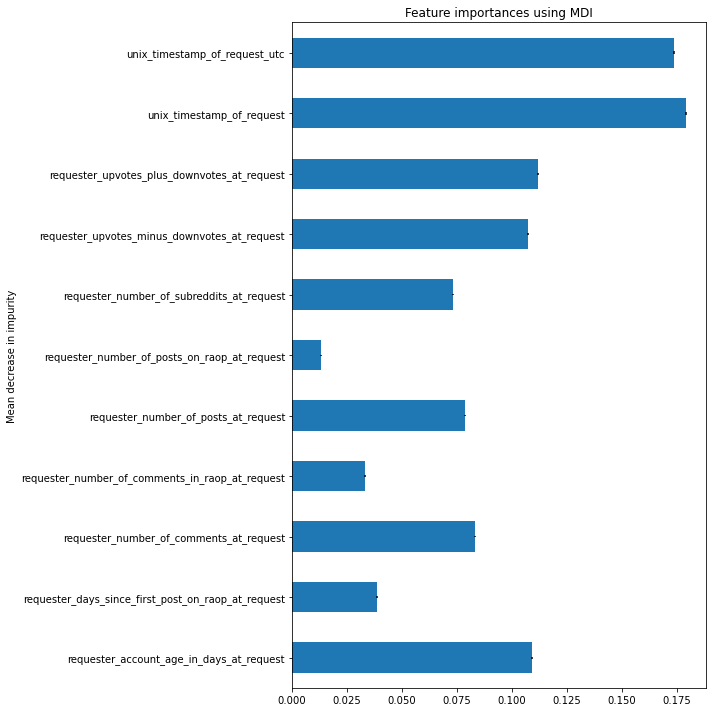

In [241]:
#Evaluate model with no transformations/scalers
#No additional features, and no parameter optimization
rf = RandomForestClassifier()
eval_model(X.copy(), rf, plot_importance = True)

## Scaling and Transformation
Given the abnormal distributions of many numerical fields in the data, we experimented with multiple transformers and scalers. 
However, ultimately none of the transformers substantially improved model performance. 

In [242]:
#Initialize list of possible scalers/transformers
transformers = [
    preprocessing.StandardScaler(),
    preprocessing.Normalizer(),
    preprocessing.MinMaxScaler(),
    preprocessing.MaxAbsScaler(),
    preprocessing.PowerTransformer(method = 'yeo-johnson')
]

#Iterate through transformers and evaluate model performance
for transformer in transformers:
    test_transformation(X.copy(), transformer)

Model accuracy w StandardScaler(): 75.17%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      1257
           1       0.09      0.36      0.14        77

    accuracy                           0.74      1334
   macro avg       0.52      0.56      0.49      1334
weighted avg       0.90      0.74      0.80      1334

-------------------------

Model accuracy w Normalizer(): 75.39%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1334
           1       0.00      0.00      0.00         0

    accuracy                           0.75      1334
   macro avg       0.50      0.38      0.43      1334
weighted avg       1.00      0.75      0.86      1334

-------------------------



C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model accuracy w MinMaxScaler(): 74.94%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1134
           1       0.20      0.32      0.24       200

    accuracy                           0.70      1334
   macro avg       0.53      0.54      0.53      1334
weighted avg       0.76      0.70      0.73      1334

-------------------------

Model accuracy w MaxAbsScaler(): 75.2%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1136
           1       0.19      0.31      0.24       198

    accuracy                           0.70      1334
   macro avg       0.53      0.54      0.52      1334
weighted avg       0.76      0.70      0.73      1334

-------------------------



C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Model accuracy w PowerTransformer(): 75.64999999999999%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1266
           1       0.08      0.37      0.13        68

    accuracy                           0.74      1334
   macro avg       0.52      0.56      0.49      1334
weighted avg       0.91      0.74      0.81      1334

-------------------------



## Sentiment Analysis
NLTK's Vader lexicon has a built-in unsupervised sentiment analyzer which scores a text as positive or negative based on pre-defined sentiment of key words. We applied the vader sentiment analyzer to text fields within the data to use as modeling fields. 

CV Model Accuracy: 76.24%
Out of Sample Performance:
[[966 288]
 [ 40  40]]
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1254
           1       0.12      0.50      0.20        80

    accuracy                           0.75      1334
   macro avg       0.54      0.64      0.53      1334
weighted avg       0.91      0.75      0.82      1334



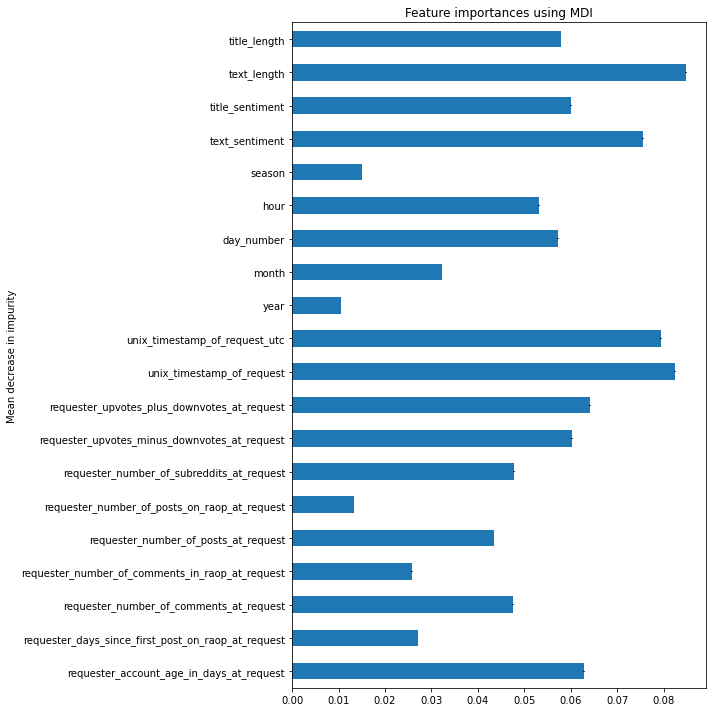

In [257]:
 def sentiment_analyze(X):
    """
    Conduct sentiment analysis of text fields
    Apply sentiment analysis results as a model feature
    Measure length of text features and apply as feature
    
    args: dataset (pandas dataframe)
    
    return: dataset + sentiment features
    """
    
    #Initialize sentiment analysis object
    sid = SentimentIntensityAnalyzer()
    
    #Copy data 
    sid_data = X.copy()
    
    #use inbuilt sid.polarity_scores to extract scores. Read on for the results
    text_analyzed = X['request_text_edit_aware'].apply(lambda request_text: sid.polarity_scores(request_text))

    #We break the dict generated above and pull only column 'compound'
    sid_data['text_sentiment']  = text_analyzed.apply(lambda s : s['compound'])

    #use inbuilt sid.polarity_scores to extract scores. Read on for the results
    title_analyzed = X['request_title'].apply(lambda request_title: sid.polarity_scores(request_title))

    #We break the dict generated above and pull only column 'compound'
    sid_data['title_sentiment']  = title_analyzed.apply(lambda s : s['compound'])

    #Measure the length of text fields and apply as feature
    sid_data['text_length']=data['request_text_edit_aware'].apply(lambda s: len(nltk.word_tokenize(s)))
    sid_data['title_length']=data['request_title'].apply(lambda s: len(nltk.word_tokenize(s)))
    
    return sid_data

eval_model(sentiment_analyze(X.copy()), rf, plot_importance=True)

## Word Vectorization
We also attempted various methods of word tokenization, beginning with a standard count vectorizer and then applying a TF-IDF transformer. 

In [244]:
def vectorize_text(X):
    """
    Given a dataset, extract text fields and countvectorize
    
    args: dataset (pandas dataframe)
    
    return: vector array 
    """
    
    #Initialize empty list of documents
    documents = []

    #Initialize stop words and lemmatizer object
    stop_words = set(stopwords.words('english'))
    stemmer = WordNetLemmatizer()

    #Iterate through text field to apply pre-processing
    for doc in X['request_text_edit_aware']:
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(doc))    
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)    
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)     
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)    
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document) 
        # Converting to Lowercase
        document = document.lower()    
        #drop stops
        document = document.split()
        document = [word for word in document if word not in stop_words]    
        #lemmatize
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        documents.append(document)
        
    #Vectorize documents
    vectorizer = CountVectorizer(max_features=100, min_df=10, max_df=0.7, stop_words=stopwords.words('english'))
    vec = vectorizer.fit_transform(documents).toarray()
    
    return vec

In [245]:
def count_vectorize(X):
    """
    Merge vectorized text array with a given dataset
    
    args: dataset (pandas dataframe)
    
    return: dataset (pandas dataframe)
    """
    
    #Merge dataset and count-vectorized text features
    vec_data = pd.merge(X, pd.DataFrame(vectorize_text(X.copy())), left_index=True, right_index=True)
    return vec_data

eval_model(count_vectorize(X.copy()), rf)

CV Model Accuracy: 75.42999999999999%
Out of Sample Performance:
[[989 296]
 [ 17  32]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1285
           1       0.10      0.65      0.17        49

    accuracy                           0.77      1334
   macro avg       0.54      0.71      0.52      1334
weighted avg       0.95      0.77      0.84      1334



In [246]:
def tfidf_vec(X):
    """
    Apply TF-IDF transformer to vectorized text array
    merge to given dataset
    
    args: dataset (pandas dataframe)
    
    return: dataset
    """
    
    #Initialize transformer and transform vectorized text
    tfidfconverter = TfidfTransformer()
    tfidf_request = tfidfconverter.fit_transform(vectorize_text(X.copy())).toarray()
    
    #Merge tf-idf array to given dataset
    tfidf_data = pd.merge(X, pd.DataFrame(tfidf_request), left_index=True, right_index=True)
    
    return tfidf_data
    
eval_model(tfidf_vec(X.copy()), rf)

CV Model Accuracy: 75.39%
Out of Sample Performance:
[[996 302]
 [ 10  26]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      1298
           1       0.08      0.72      0.14        36

    accuracy                           0.77      1334
   macro avg       0.53      0.74      0.50      1334
weighted avg       0.97      0.77      0.85      1334



## Failed Experiment: Naive Bayes Feature Engineering
We attempted to engineer features from the text fields by using a Multinomial Naive Bayes model to extract text weights which could be used as modeling features. However, this ultimately had negligible impact on model performance. 

In [247]:
# Column labels that have text fields
def nb_features(X):
    """
    Calculate Naive Bayes text weights for text fields in a given dataset
    Apply text weights as modeling features
    
    args: dataset (pandas dataframe)
    
    return: dataset
    """
    
    #Name text columns for analysis
    text_columns = ['request_text', 'request_text_edit_aware', 'request_title']
    
    #Copy data
    nb_data = X.copy()
    new_features = []
    # Looping thru each text field
    for field in text_columns:
        # Getting corpus for current field
        corpus = X[field]

        # Defining vectorizer and getting 
        vec = CountVectorizer()
        matrix = vec.fit_transform(corpus).toarray()

        # Naive bayes classifier fitted
        clf = MultinomialNB()
        clf.fit(matrix, y)

        # Getting coefficients for each word in corpus
        coefs = clf.coef_

        # Initializing list for new feature
        text_weights = []

        # Looping thru each text, multiply coefficient weights by frequencies, add to new feature vector
        for row in matrix:
            weight = (coefs * row).sum()
            text_weights.append(weight)

        # Making copy of X data and adding our new feature
        nb_data[field] = text_weights

    return nb_data, clf

#nb_data, nb_clf = nb_features(X.copy())
#eval_model(nb_data, plot_importance=True)

## Timestamp Features
Because the timestamp features were rated as highly important in feature importance testing, we believed there to be strong signal in the time-series nature of the data. To extract more signal from these fields, we broke the timestamps down into subordinate fields for modeling. 

CV Model Accuracy: 74.69%
Out of Sample Performance:
[[940 287]
 [ 66  41]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1227
           1       0.12      0.38      0.19       107

    accuracy                           0.74      1334
   macro avg       0.53      0.57      0.52      1334
weighted avg       0.87      0.74      0.79      1334



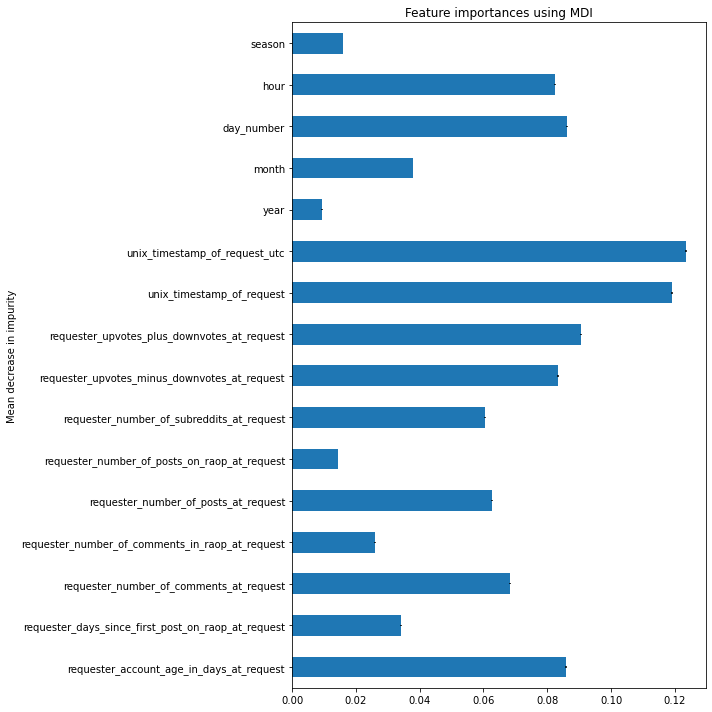

In [248]:
# Adding timestamp column to dataframe
def determine_season(row):
    """
    Given a dataframe observation, 
    Extract the season (spring, summer, etc)
    
    args: observation (row of pandas dataframe)
    
    return: int
    """
    
    #Check month int and return appropriate season
    month = row.month
    if month < 4:
        return 0
    if month < 7:
        return 1
    if month < 10:
        return 2
    return 3

def apply_time(X):
    """
    Given dataset, extract timestamp
    Apply year, month, day, hour, season
    as modeling features. 
    
    args: dataset (pandas dataframe)
    
    return: dataset
    """
    
    #Extract timestamp as datetime string
    X['date_hour'] = X.apply(lambda row: datetime.fromtimestamp(row.unix_timestamp_of_request).strftime('%Y-%m-%d-%H'), 
                                   axis = 1)

    # Creating Adding New columns for year, month, day_number, hour, and season
    X['year'] = pd.DataFrame(X.apply(lambda row: int(row.date_hour.split('-')[0]), axis = 1))
    X['month'] = pd.DataFrame(X.apply(lambda row: int(row.date_hour.split('-')[1]), axis = 1))
    X['day_number'] = pd.DataFrame(X.apply(lambda row: int(row.date_hour.split('-')[2]), axis = 1))
    X['hour'] =  pd.DataFrame(X.apply(lambda row: int(row.date_hour.split('-')[3]), axis = 1))
    X['season'] = pd.DataFrame(X.apply(lambda row: determine_season(row), axis = 1))
    
    return X

eval_model(apply_time(X.copy()), rf, plot_importance=True)

## Final Modeling
After iterative experimentation, we kept the time features, sentiment features, and count vectorized features for modeling. We then iterated through multiple classification frameworks to ensure the optimal model was selected, and conducted random grid searching to optimize parameters. Finally, the model was trained on the entirety of the training data available and submissions are written out to .csv. 

In [249]:
#Create new dataset applying all feature engineering functions
model_data = apply_time(X)
model_data = sentiment_analyze(model_data)
model_data = count_vectorize(model_data)

#Evaluate model
eval_model(model_data, rf)

CV Model Accuracy: 75.61%
Out of Sample Performance:
[[996 302]
 [ 10  26]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      1298
           1       0.08      0.72      0.14        36

    accuracy                           0.77      1334
   macro avg       0.53      0.74      0.50      1334
weighted avg       0.97      0.77      0.85      1334



In [250]:
#Iterate through multiple modeling frameworks to choose optimal model
models = [RandomForestClassifier(), LogisticRegression(), SVC()]
for model in models:
    print(model)
    eval_model(model_data, model)

RandomForestClassifier()
CV Model Accuracy: 75.76%
Out of Sample Performance:
[[991 297]
 [ 15  31]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      1288
           1       0.09      0.67      0.17        46

    accuracy                           0.77      1334
   macro avg       0.54      0.72      0.51      1334
weighted avg       0.95      0.77      0.84      1334

LogisticRegression()
CV Model Accuracy: 75.39%
Out of Sample Performance:
[[1006  328]
 [   0    0]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1334
           1       0.00      0.00      0.00         0

    accuracy                           0.75      1334
   macro avg       0.50      0.38      0.43      1334
weighted avg       1.00      0.75      0.86      1334

SVC()


C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV Model Accuracy: 75.39%
Out of Sample Performance:
[[1006  328]
 [   0    0]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1334
           1       0.00      0.00      0.00         0

    accuracy                           0.75      1334
   macro avg       0.50      0.38      0.43      1334
weighted avg       1.00      0.75      0.86      1334



C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [251]:
#Extract only int and float features from final dataset
model_data = model_data.select_dtypes(np.number)
#test train split
X_train, X_test, y_train, y_test = train_test_split(model_data, y, test_size=0.33, random_state=42, stratify=y)

#Initialize list of parameters for randomized search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#Conduct random parameter search to identify optimal parameters
rf = RandomForestClassifier()
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.2s finished


{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}


In [252]:
#Create and evaluate a model using optimal parameters
optimized_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['n_estimators']
)

eval_model(model_data, optimized_rf)

CV Model Accuracy: 76.2%
Out of Sample Performance:
[[998 300]
 [  8  28]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      1298
           1       0.09      0.78      0.15        36

    accuracy                           0.77      1334
   macro avg       0.54      0.77      0.51      1334
weighted avg       0.97      0.77      0.85      1334



In [253]:
#Initialize a final model for submission
final_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['n_estimators']
)

#Fit the model on all training data available
final_rf.fit(model_data, y)

#Load test data and engineer features
test_data = pd.read_json('data/test/test.json')
test_data = apply_time(test_data)
test_data = sentiment_analyze(test_data)
test_data = count_vectorize(test_data)

test_data = test_data.select_dtypes(np.number)

In [254]:
#Make predictions
yhat = final_rf.predict(test_data)

In [255]:
#Create and write submission file
submission = pd.DataFrame(data = {
    'request_id': list(pd.read_json('data/test/test.json')['request_id']),
    'requester_received_pizza': yhat
})

submission.to_csv('submission.csv')